In [1]:
from dasly import dasly, helper
import numpy as np
import pandas as pd

In [2]:
# folder_path = '/mnt/Datastore/usr/kptruong/Svalbard_whale/dphi_1220'
folder_path = '/mnt/Datastore/usr/kptruong/Svalbard_whale/20220822'
file_paths = helper.find_hdf5(folder_path)
# file_paths = file_paths[8:8+6]
# file_paths = file_paths[0:6]
file_paths = file_paths[49+3:49+6]
file_paths

['/mnt/Datastore/usr/kptruong/Svalbard_whale/20220822/dphi/122839.hdf5',
 '/mnt/Datastore/usr/kptruong/Svalbard_whale/20220822/dphi/122849.hdf5',
 '/mnt/Datastore/usr/kptruong/Svalbard_whale/20220822/dphi/122859.hdf5']

In [3]:
das = dasly.Dasly()
das.load_data(file_paths=file_paths)
print(das.signal.shape)

(18750, 33748)


In [4]:
np.nan is np.nan

True

In [5]:
das.reset()

In [6]:
# das.signal = das.signal.loc[:, 50000:97500]
das.signal = das.signal.loc[:, 50000:70000]

Signal updated with band-pass filter.


(18750, 5001)


vmin: -2.99e-08, vmax: 2.99e-08


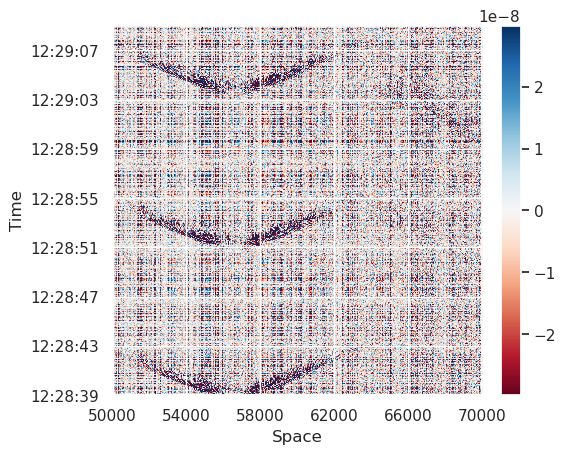

In [7]:
das.bandpass_filter(15, 25)
print(das.signal.shape)
das.heatmap()

Signal updated with new temporal sampling rate 2e+01 and new spatial sampling rate 0.01.
vmin: -6.07e-10, vmax: 6.07e-10


(750, 201)


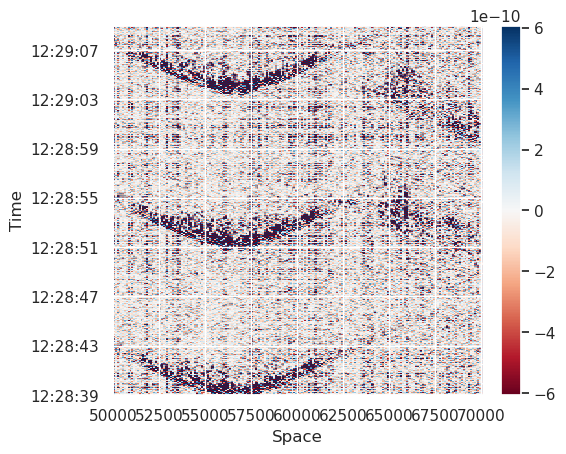

In [8]:
das.sample(meters=100, seconds=1/25, func_name='mean')
print(das.signal.shape)
das.heatmap()

Signal updated with Gaussian smoothing.
vmax: 3.89e-10


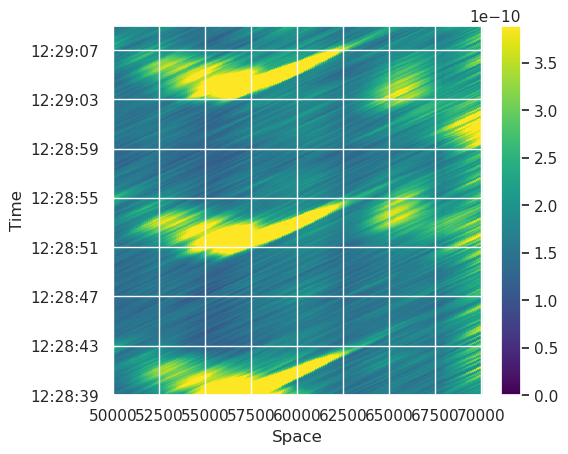

In [9]:
das.signal = np.abs(das.signal)
das.gaussian_smooth(1500, 1500.01, unit='m/s', std_s=1000)
das.heatmap()

vmax: 0.00198


(69, 41)
25.0
0.01


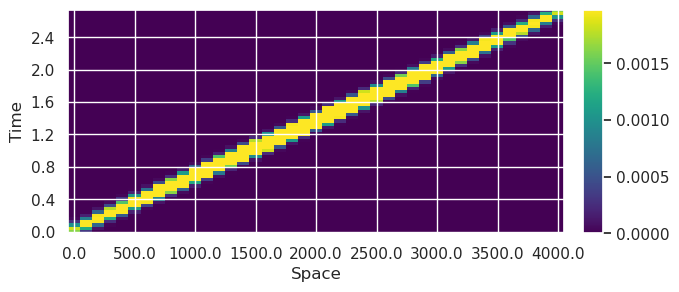

In [10]:
print(das.gauss_kernel.shape)
print(das.t_rate)
print(das.s_rate)
das.heatmap(
    das.gauss_kernel,
    aspect=das.signal.shape[1]/das.signal.shape[0]
)

Signal updated with Sobel filter.
vmax: 1.78e-10


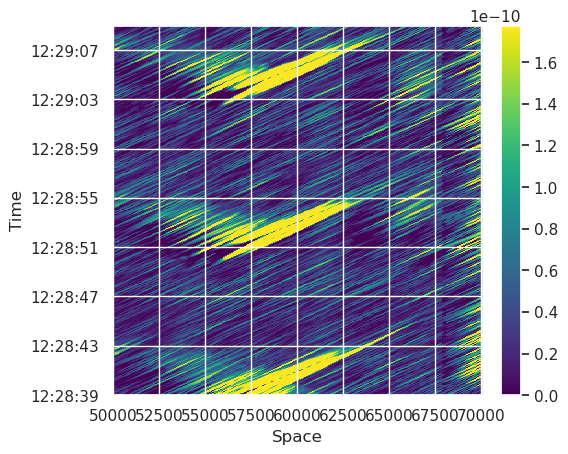

In [11]:
das.sobel_filter()
das.heatmap()

Signal updated with binary transform with threshold 1.78e-10.


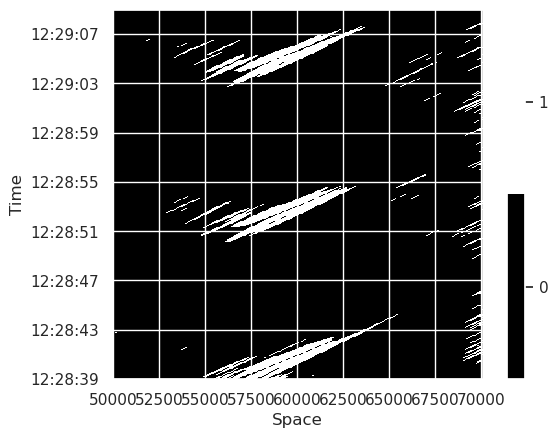

In [12]:

das.binary_transform(0.95)
das.heatmap()

26 lines are detected.


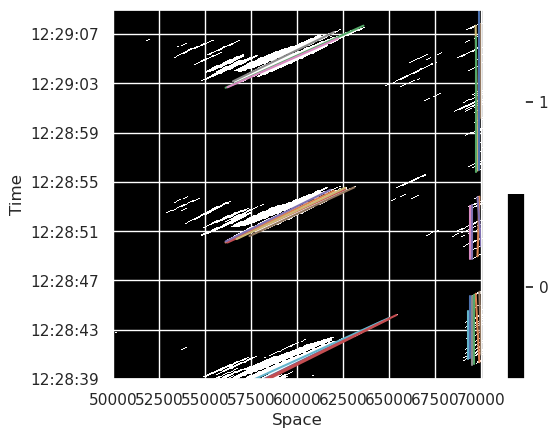

In [13]:
das.hough_transform(target_speed=1500, speed_res=10, length_meters=5000, speed_unit='m/s')
das.heatmap()

In [16]:
das.dbscan(eps_seconds=1)

In [49]:
from datetime import datetime, timedelta, time

In [107]:
func_name = 'mean'

lines_df = (
    pd.DataFrame(das.lines, columns=['x1', 'y1', 'x2', 'y2'])
    .assign(cluster=das.cluster)
    .groupby('cluster')
    .agg(
        x1=('x1', func_name),
        y1=('y1', func_name),
        x2=('x2', func_name),
        y2=('y2', func_name),
        count=('cluster', 'count'))
    .astype(int)
    .reset_index()
    .assign(
        s1=lambda df: das.signal.columns[df['x1']],
        t1=lambda df: das.signal.index[df['y1']],
        s2=lambda df: das.signal.columns[df['x2']],
        t2=lambda df: das.signal.index[df['y2']],
        s=lambda df: df['s2'] - df['s1'],
    )
)

if isinstance(lines_df['t1'][0], pd.Timestamp):
    # If both are pandas timestamps, just calculate the difference
    lines_df = (
        lines_df
        .assign(
            t=lambda df: (lines_df['t2'] - lines_df['t1']).dt.total_seconds(),
            speed=lambda df: df['s'] / df['t'])
    )
elif isinstance(lines_df['t1'][0], time):
    # If both are datetime.time objects (only time, not date),
    # convert them to Timedelta  using list comprehensions    
    start_td = pd.to_timedelta(
        [timedelta(
            hours=t.hour,
            minutes=t.minute,
            seconds=t.second,
            microseconds=t.microsecond)
         for t in lines_df['t1']]
        )
    end_td = pd.to_timedelta(
        [timedelta(
            hours=t.hour,
            minutes=t.minute,
            seconds=t.second,
            microseconds=t.microsecond)
         for t in lines_df['t2']]
    )
    lines_df = (
        lines_df
        .assign(
            t=(end_td - start_td).total_seconds(),
            speed=lambda df: df['s'] / df['t'])
    )

In [97]:
lines_df

,cluster,x1,y1,x2,y2,count,s1,t1,s2,t2,s,t,speed
0,0,81,0,150,123,4,58100,12:28:39,65000,12:28:43.920000,6900,4.92,1402.439024
1,1,65,281,124,385,5,56500,12:28:50.240000,62400,12:28:54.400000,5900,4.16,1418.269231
2,2,62,595,126,704,3,56200,12:29:02.800000,62600,12:29:07.160000,6400,4.36,1467.889908
3,3,197,705,197,422,2,69700,12:29:07.200000,69700,12:28:55.880000,0,-11.32,-0.000000
4,4,199,749,199,424,1,69900,12:29:08.960000,69900,12:28:55.960000,0,-13.00,-0.000000
5,5,197,173,199,34,1,69700,12:28:45.920000,69900,12:28:40.360000,200,-5.56,-35.971223
6,6,196,171,196,30,1,69600,12:28:45.840000,69600,12:28:40.200000,0,-5.64,-0.000000
7,7,195,244,195,353,1,69500,12:28:48.760000,69500,12:28:53.120000,0,4.36,0.000000
8,8,199,177,200,49,1,69900,12:28:46.080000,70000,12:28:40.960000,100,-5.12,-19.531250
9,9,194,351,194,243,1,69400,12:28:53.040000,69400,12:28:48.720000,0,-4.32,-0.000000


In [130]:
def lines_inter_edges(lines, width, height) -> pd.DataFrame:

    lines = np.array(lines).reshape(-1, 4)

    x1 = lines[:, 0]
    y1 = lines[:, 1]
    x2 = lines[:, 2]
    y2 = lines[:, 3]

    # Calculate slopes (m) and intercepts (c)
    m = np.divide(
        (y2 - y1),
        (x2 - x1),
        out=np.zeros_like(y1, dtype=float),
        where=(x2 - x1) != 0
    )
    c = y1 - m * x1

    # Calculate intersection points with all edges
    y_left = c
    y_right = m * width + c
    x_top = -c / m
    x_bottom = (height - c) / m

    # Stack and filter valid intersections within image boundaries
    left_edges = np.stack([np.zeros_like(y_left), y_left], axis=-1)
    right_edges = np.stack(
        [np.full_like(y_right, width), y_right], axis=-1)
    top_edges = np.stack([x_top, np.zeros_like(x_top)], axis=-1)
    bottom_edges = np.stack(
        [x_bottom, np.full_like(x_bottom, height)], axis=-1)

    valid_left = (0 <= y_left) & (y_left <= height)
    valid_right = (0 <= y_right) & (y_right <= height)
    valid_top = (0 <= x_top) & (x_top <= width)
    valid_bottom = (0 <= x_bottom) & (x_bottom <= width)

    # Collect intersections in the same shape as the input lines
    intersections = np.zeros((lines.shape[0], 4, 2), dtype=int)
    intersections[:] = -1  # Initialize with -1 (invalid marker)

    intersections[valid_left, 0] = left_edges[valid_left]
    intersections[valid_right, 1] = right_edges[valid_right]
    intersections[valid_top, 2] = top_edges[valid_top]
    intersections[valid_bottom, 3] = bottom_edges[valid_bottom]

    return intersections

In [131]:
a = lines_inter_edges(das.lines, width=das.signal.shape[1], height=das.signal.shape[0])
a.shape

/tmp/ipykernel_921601/3256736840.py:22: RuntimeWarning: divide by zero encountered in divide
  x_top = -c / m
/tmp/ipykernel_921601/3256736840.py:23: RuntimeWarning: divide by zero encountered in divide
  x_bottom = (height - c) / m


(26, 4, 2)

In [129]:
a

array([[[ -1,  -1],
        [201, 217],
        [ 82,   0],
        [ -1,  -1]],

       [[  0, 168],
        [201, 526],
        [ -1,  -1],
        [ -1,  -1]],

       [[  0, 488],
        [ -1,  -1],
        [ -1,  -1],
        [155, 750]],

       [[  0, 172],
        [201, 511],
        [ -1,  -1],
        [ -1,  -1]],

       [[  0, 166],
        [201, 536],
        [ -1,  -1],
        [ -1,  -1]],

       [[  0, 161],
        [201, 510],
        [ -1,  -1],
        [ -1,  -1]],

       [[  0, 489],
        [ -1,  -1],
        [ -1,  -1],
        [157, 750]],

       [[  0, 485],
        [ -1,  -1],
        [ -1,  -1],
        [145, 750]],

       [[ -1,  -1],
        [ -1,  -1],
        [199,   0],
        [196, 750]],

       [[ -1,  -1],
        [201, 210],
        [ 77,   0],
        [ -1,  -1]],

       [[  0, 749],
        [201, 749],
        [ -1,  -1],
        [ -1,  -1]],

       [[ -1,  -1],
        [ -1,  -1],
        [199,   0],
        [188, 750]],

       [[  0, 17

In [120]:
import numpy as np
import cv2

def compute_intersections_vectorized(lines, width, height):
    lines = np.array(lines).reshape(-1, 4)

    x1 = lines[:, 0]
    y1 = lines[:, 1]
    x2 = lines[:, 2]
    y2 = lines[:, 3]

    # Calculate slopes (m) and intercepts (c)
    m = np.divide((y2 - y1), (x2 - x1), out=np.zeros_like(y1, dtype=float), where=(x2 - x1) != 0)
    c = y1 - m * x1

    # Calculate intersection points with all edges
    y_left = c
    y_right = m * width + c
    x_top = -c / m
    x_bottom = (height - c) / m

    # Stack and filter valid intersections within image boundaries
    left_edges = np.stack([np.zeros_like(y_left), y_left], axis=-1)
    right_edges = np.stack([np.full_like(y_right, width), y_right], axis=-1)
    top_edges = np.stack([x_top, np.zeros_like(x_top)], axis=-1)
    bottom_edges = np.stack([x_bottom, np.full_like(x_bottom, height)], axis=-1)

    valid_left = (0 <= y_left) & (y_left <= height)
    valid_right = (0 <= y_right) & (y_right <= height)
    valid_top = (0 <= x_top) & (x_top <= width)
    valid_bottom = (0 <= x_bottom) & (x_bottom <= width)

    # Collect intersections in the same shape as the input lines
    intersections = np.zeros((lines.shape[0], 4, 2), dtype=int)
    intersections[:] = -1  # Initialize with -1 (invalid marker)

    intersections[valid_left, 0] = left_edges[valid_left]
    intersections[valid_right, 1] = right_edges[valid_right]
    intersections[valid_top, 2] = top_edges[valid_top]
    intersections[valid_bottom, 3] = bottom_edges[valid_bottom]

    return intersections

# Example usage
image = cv2.imread('example.jpg')
height, width = image.shape[:2]

# Example lines from HoughLinesP output
lines = np.array([[[10, 20, 100, 200]], [[30, 40, 150, 250]], [[50, 60, 200, 300]]])

# Compute intersections
intersections = compute_intersections_vectorized(lines, width, height)

# Print intersections
for line_intersections in intersections:
    for point in line_intersections:
        if point[0] != -1 and point[1] != -1:  # Check if the point is valid
            print(tuple(point))

[ WARN:0@9396.962] global /croot/opencv-suite_1691620365762/work/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('example.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

In [37]:
from datetime import datetime, timedelta, time
time0 = pd.Timestamp('2023-07-09 14:30:00')
common_date = datetime.today()
datetime0 = datetime.combine(common_date, time0)

TypeError: combine() argument 2 must be datetime.time, not Timestamp

In [51]:
import pandas as pd
from datetime import datetime, time, timedelta

# Sample DataFrame
data = {
    'col1': [pd.Timestamp('2023-07-09 14:30:00'), time(12, 15), pd.Timestamp('2023-07-09 09:00:00')],
    'col2': [pd.Timestamp('2023-07-09 12:15:00'), time(10, 15), time(8, 45)]
}
df = pd.DataFrame(data)

# Function to convert datetime.time to pd.Timestamp
def to_timestamp(val):
    if isinstance(val, pd.Timestamp):
        return val
    elif isinstance(val, time):
        return pd.Timestamp.combine(pd.Timestamp.today(), val)
    else:
        raise ValueError("Unsupported data type")

# Apply the conversion function to both columns
df['timestamp1'] = df['col1'].apply(to_timestamp)
df['timestamp2'] = df['col2'].apply(to_timestamp)

# Calculate the difference in seconds
df['time_difference_seconds'] = (df['timestamp1'] - df['timestamp2']).dt.total_seconds()

print(df)

                  col1                 col2          timestamp1  \
0  2023-07-09 14:30:00  2023-07-09 12:15:00 2023-07-09 14:30:00   
1             12:15:00             10:15:00 2024-07-09 12:15:00   
2  2023-07-09 09:00:00             08:45:00 2023-07-09 09:00:00   

           timestamp2  time_difference_seconds  
0 2023-07-09 12:15:00                   8100.0  
1 2024-07-09 10:15:00                   7200.0  
2 2024-07-09 08:45:00              -31621500.0  


In [135]:
import numpy as np

def process_hough_lines(lines, height, width):
    # Step 1: Reshape the output from shape (N, 1, 4) to (N, 4)
    lines = lines.reshape(-1, 4)
    
    # Extract coordinates
    x1, y1, x2, y2 = lines[:, 0], lines[:, 1], lines[:, 2], lines[:, 3]

    # Calculate line parameters
    a = y2 - y1
    b = x1 - x2
    c = x2 * y1 - x1 * y2
    
    # Define image edges
    edges = {
        'top': (0, 1, 0),            # y = 0 (top edge)
        'bottom': (0, 1, -height),   # y = height (bottom edge)
        'left': (1, 0, 0),           # x = 0 (left edge)
        'right': (1, 0, -width)      # x = width (right edge)
    }

    # Function to calculate intersection
    def intersection(a1, b1, c1, a2, b2, c2):
        det = a1 * b2 - a2 * b1
        x = (b1 * c2 - b2 * c1) / det
        y = (a2 * c1 - a1 * c2) / det
        return x, y

    # Calculate intersections with each edge
    intersections = {edge: intersection(a, b, c, *params) for edge, params in edges.items()}

    # Step 2: Calculate intersections with the vertical edges extended
    vertical_edges = ['left', 'right']
    vertical_intersections = {edge: intersection(a, b, c, *edges[edge]) for edge in vertical_edges}

    # Filter valid intersections (within image bounds for the four edges)
    def filter_valid_intersections(intersections, width, height):
        valid_intersections = {}
        for edge, (x, y) in intersections.items():
            if edge in ['top', 'bottom']:
                valid_mask = (x >= 0) & (x <= width)
            elif edge in ['left', 'right']:
                valid_mask = (y >= 0) & (y <= height)
            valid_intersections[edge] = (x[valid_mask], y[valid_mask])
        return valid_intersections

    valid_intersections = filter_valid_intersections(intersections, width, height)

    return valid_intersections, vertical_intersections

# Example usage:
lines = np.array([[[10, 10, 200, 200]], [[50, 50, 250, 100]], [[30, 250, 300, 30]]])  # Example HoughLinesP output
height, width = 300, 300  # Example image size
valid_intersections, vertical_intersections = process_hough_lines(lines, height, width)

print("Valid intersections with image edges:", valid_intersections)
print("Intersections with vertical edges extended:", vertical_intersections)

Valid intersections with image edges: {'top': (array([0.]), array([0.])), 'bottom': (array([300.]), array([300.])), 'left': (array([0., 0., 0.]), array([  0.        ,  37.5       , 274.44444444])), 'right': (array([300., 300., 300.]), array([300. , 112.5,  30. ]))}
Intersections with vertical edges extended: {'left': (array([0., 0., 0.]), array([  0.        ,  37.5       , 274.44444444])), 'right': (array([300., 300., 300.]), array([300. , 112.5,  30. ]))}


In [136]:
valid_intersections

{'top': (array([0.]), array([0.])),
 'bottom': (array([300.]), array([300.])),
 'left': (array([0., 0., 0.]),
  array([  0.        ,  37.5       , 274.44444444])),
 'right': (array([300., 300., 300.]), array([300. , 112.5,  30. ]))}